# Reconocimiento de comandos de voz con CNN 1D

Curso: [Introducción al Aprendizaje Profundo](http://turing.iimas.unam.mx/~ricardoml/course/iap/). Profesores: [Bere](https://turing.iimas.unam.mx/~bereml/) y [Ricardo](https://turing.iimas.unam.mx/~ricardoml/) Montalvo Lezama.

---
---

En esta libreta veremos un ejemplo de clasificación de audio empleando formas de onda y redes convolucionales 1D. 

[Speech Commands](https://arxiv.org/abs/1804.03209) es un conjunto de comandos de voz (palabras) con más de 100k ejemplos. Cada audio dura alrededor de 1 segundo y tienen un solo canal de voz con una frecuencia de muestreo de 16000hz.

<img src="https://d3i71xaburhd42.cloudfront.net/da6e404d8911b0e5785019a79dc8607e0b313dc4/7-Figure1-1.png"  style="width: 200px;" />

## 1. Preparación

In [1]:
# Colab
! pip install torchinfo
try:
    import torchaudio
except:
    ! pip install torchaudio

### 1.1. Bibliotecas

In [2]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take

# audio
import librosa
import librosa.display

# reproductor
import IPython as ip
# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np

# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# redes audio
import torchaudio
import torchaudio.transforms as T
# redes visión
import torchvision.models as tvm

# redes neuronales
from torch.utils.data import DataLoader
from torchaudio.datasets import SPEECHCOMMANDS
# inspección de arquitectura
from torchinfo import summary

# barras de progreso
from tqdm.auto import tqdm, trange

### 1.2. Auxiliares

In [3]:
# directorio de datos
DATA_DIR = '../datos/speech_commands'

# tamaño del lote
BATCH_SIZE = 32

# parámetros de audio
SECS = 1
SAMPLE_RATE = 16000

# SpeechCommands classes
CLASSES = (
    'backward', 'bed', 'bird', 'cat', 'dog',
    'down', 'eight', 'five', 'follow', 'forward',
    'four', 'go', 'happy', 'house', 'learn', 
    'left', 'marvin', 'nine', 'no', 'off', 
    'on', 'one', 'right', 'seven', 'sheila',
    'six', 'stop', 'three', 'tree', 'two',
    'up', 'visual', 'wow', 'yes', 'zero'
)
NUM_CLASSES = len(CLASSES)
CLASS_IDX = {c: i for i, c in enumerate(CLASSES)}

    
def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    
# reproducibilidad
set_seed()

## 2. Datos

### 2.1. Descarga

In [4]:
! mkdir -p {DATA_DIR}

In [5]:
ds = SPEECHCOMMANDS(DATA_DIR, download=True)

In [6]:
len(ds)

105829

In [7]:
! ls -R {DATA_DIR} | head -55

../datos/speech_commands:
SpeechCommands
speech_commands_v0.02.tar.gz

../datos/speech_commands/SpeechCommands:
speech_commands_v0.02

../datos/speech_commands/SpeechCommands/speech_commands_v0.02:
_background_noise_
backward
bed
bird
cat
dog
down
eight
five
follow
forward
four
go
happy
house
learn
left
LICENSE
marvin
nine
no
off
on
one
README.md
right
seven
sheila
six
stop
testing_list.txt
three
tree
two
up
validation_list.txt
visual
wow
yes
zero

../datos/speech_commands/SpeechCommands/speech_commands_v0.02/_background_noise_:
doing_the_dishes.wav
dude_miaowing.wav
exercise_bike.wav
pink_noise.wav
README.md


### 2.2. Conjunto de datos

In [8]:
def identity(x):
    return x


def label2index(label):
    return CLASS_IDX[label]


class SPEECHCOMMANDS2(SPEECHCOMMANDS):

    def __init__(self, root, download=False, subset=None,
                 waveform_tsfm=identity, label_tsfm=identity):
        super().__init__(root=root, download=download, subset=subset)
        self.waveform_tsfm = waveform_tsfm
        self.label_tsfm = label_tsfm

    def __getitem__(self, i):
        waveform, sample_rate, label, *_ = super().__getitem__(i)
        x = self.waveform_tsfm(waveform)
        y = self.label_tsfm(label)
        return x, y, label, sample_rate

### 2.3. Transformación para la forma de onda

In [9]:
class WaveformPadTruncate(nn.Module):

    def __init__(self, secs=SECS, sample_rate=SAMPLE_RATE):
        super().__init__()
        self.samples = secs * sample_rate
    
    def forward(self, waveform):
        samples = waveform.shape[1]
        
        if samples < self.samples:
            difference = self.samples - samples
            padding = torch.zeros(1, difference)
            waveform = torch.cat([waveform, padding], 1)

        elif samples > self.samples:
            start = random.randint(0, waveform.shape[1] - self.samples)
            waveform = waveform.narrow(1, start, self.samples)
        
        return waveform
        
        
        start = random.randint(0, waveform.shape[1] - self.samples)
        waveform = waveform.narrow(1, start, self.samples)
        return waveform

### 2.4. Inspección del conjunto

In [10]:
# creamos un Dataset
ds = SPEECHCOMMANDS2(
    # directorio de datos
    root=DATA_DIR,
    # transformación de la forma de onda
    waveform_tsfm=WaveformPadTruncate(),
    # transformación de etiqueta
    label_tsfm=label2index,
)

# creamos un DataLoader
dl = DataLoader(
    # conjunto
    ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
)

# desplegamos un lote de imágenes
x, y, labels, sr = next(iter(dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([32, 1, 16000]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


### 2.5. Cargador de datos

In [11]:
def build_dl(subset=None, shuffle=False):
    
    waveform_tsfm = WaveformPadTruncate()
        
    # creamos un Dataset
    ds = SPEECHCOMMANDS2(
        # directorio de datos
        root=DATA_DIR,
        # subconjunto
        subset=subset,
        # transformación de la forma de onda
        waveform_tsfm=waveform_tsfm,
        # transformación de etiqueta
        label_tsfm=label2index,
    )

    # creamos un DataLoader
    dl = DataLoader(
        # conjunto
        ds,
        # tamaño del lote
        batch_size=BATCH_SIZE,
        # barajear
        shuffle=shuffle,
    )
    return dl

### 2.6. Entrenamiento

x shape=torch.Size([32, 1, 16000]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


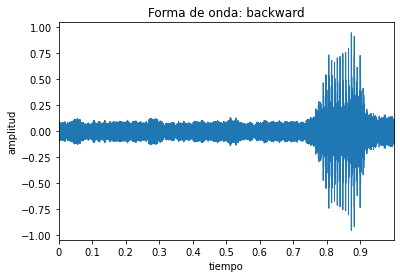

In [12]:
dl = build_dl(subset='training')

# inspeccionemos el lote
x, y, labels, sr = next(iter(dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')

# inspeccionemos un ejemplo
waveform = x[0].squeeze().numpy()
label = labels[0]

# grafiquemos forma de onda
librosa.display.waveplot(waveform, sr=SAMPLE_RATE)
plt.title(f'Forma de onda: {label}')
plt.xlabel('tiempo')
plt.ylabel('amplitud')
plt.show()

# reproductor
ip.display.Audio(waveform, rate=SAMPLE_RATE)

### 2.7. Validación

x shape=torch.Size([32, 1, 16000]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int64


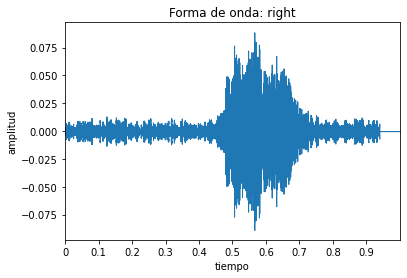

In [13]:
dl = build_dl(subset='validation')

# inspeccionemos el lote
x, y, labels, sr = next(iter(dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')

# inspeccionemos un ejemplo
waveform = x[0].squeeze().numpy()
label = labels[0]

# grafiquemos forma de onda
librosa.display.waveplot(waveform, sr=SAMPLE_RATE)
plt.title(f'Forma de onda: {label}')
plt.xlabel('tiempo')
plt.ylabel('amplitud')
plt.show()

# reproductor
ip.display.Audio(waveform, rate=SAMPLE_RATE)

## 3. Ciclo de entrenamiento

In [14]:
def train_epoch(dl, model, opt, device):

    # por cada lote
    for x, y_true, *_ in tqdm(dl, leave=False):

        # movemos a dispositivo
        x = x.to(device)
        y_true = y_true.to(device)

        # computamos logits
        y_lgts = model(x)

        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)

        # vaciamos los gradientes
        opt.zero_grad()

        # retropropagamos
        loss.backward()

        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, device, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true, *_ in tqdm(take(dl, num_batches), leave=False):

            # movemos a dispositivo
            x = x.to(device)
            y_true = y_true.to(device)

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, tst_dl, lr=1e-4, epochs=20,
          trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.Adam(model.parameters(), lr=lr)

    # usamos GPU si está disponible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # movemos a dispositivo
    model.to(device)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # modelo en modo de entrenamiento
        model.train()
        # entrenamos la época
        train_epoch(trn_dl, model, opt, device)

        # modelo en modo de evaluación
        model.eval()
        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, device, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, device, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist




## 4. Arquitectura

El siguiente diseño es una versión simplificada de la arquitectura M5 presentada [Dai. y col. en 
Very Deep Convolutional Neural Networks for Raw Waveforms](https://arxiv.org/abs/1610.00087).

In [15]:
class M3(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES):
        super(M3, self).__init__()
        self.conv1 = nn.Conv1d(1, 256, 80, 4)
        self.bn1 = nn.BatchNorm1d(256)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(256, 256, 3)
        self.bn2 = nn.BatchNorm1d(256)
        self.pool2 = nn.MaxPool1d(4)
        self.avgPool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = self.avgPool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

class M5(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES):
        super(M5, self).__init__()
        self.conv1 = nn.Conv1d(1, 128, 80, 4)
        self.bn1 = nn.BatchNorm1d(128)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(128, 128, 3)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(128, 256, 3)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(256, 512, 3)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(4)
        self.avgPool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = self.avgPool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x


class M11(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES):
        super(M11, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, 80, 4)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(4)
        
        self.conv2 = nn.Conv1d(64, 64, 3) 
        self.conv21 = nn.Conv1d(64, 64, 3) 
        self.bn2 = nn.BatchNorm1d(64)
        self.bn21 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(4)
        
        self.conv3 = nn.Conv1d(64, 128, 3)
        self.conv31 = nn.Conv1d(128, 128, 3)
        self.bn3 = nn.BatchNorm1d(128)
        self.bn31 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(4)
        
        self.conv4 = nn.Conv1d(128, 256, 3)
        self.conv41 = nn.Conv1d(256, 256, 3)
        self.conv42 = nn.Conv1d(256, 256, 3)
        self.bn4 = nn.BatchNorm1d(256)
        self.bn41 = nn.BatchNorm1d(256)
        self.bn42 = nn.BatchNorm1d(256)
        self.pool4 = nn.MaxPool1d(4)
        
        self.conv5 = nn.Conv1d(256, 512, 3)
        self.conv51 = nn.Conv1d(512, 512, 3)
        self.bn5 = nn.BatchNorm1d(512)
        self.bn51 = nn.BatchNorm1d(512)

        self.avgPool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn21(self.conv21(x)))
        x = self.pool2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn31(self.conv31(x)))
        x = self.pool3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn41(self.conv41(x)))
        x = F.relu(self.bn42(self.conv42(x)))
        x = self.pool4(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn51(self.conv51(x)))
        x = self.avgPool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

class M18(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES):
        super(M18, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, 80, 4)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(4)
        
        self.conv2 = nn.Conv1d(64, 64, 3) 
        self.conv21 = nn.Conv1d(64, 64, 3)
        self.conv22 = nn.Conv1d(64, 64, 3)
        self.conv23 = nn.Conv1d(64, 64, 3)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn21 = nn.BatchNorm1d(64)
        self.bn22 = nn.BatchNorm1d(64)
        self.bn23 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(4)
        
        self.conv3 = nn.Conv1d(64, 128, 3)
        self.conv31 = nn.Conv1d(128, 128, 3)
        self.conv32 = nn.Conv1d(128, 128, 3)
        self.conv33 = nn.Conv1d(128, 128, 3)
        self.bn3 = nn.BatchNorm1d(128)
        self.bn31 = nn.BatchNorm1d(128)
        self.bn32 = nn.BatchNorm1d(128)
        self.bn33 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(4)
        
        self.conv4 = nn.Conv1d(128, 256, 3)
        self.conv41 = nn.Conv1d(256, 256, 3)
        self.conv42 = nn.Conv1d(256, 256, 3)
        self.conv43 = nn.Conv1d(256, 256, 3)
        self.bn4 = nn.BatchNorm1d(256)
        self.bn41 = nn.BatchNorm1d(256)
        self.bn42 = nn.BatchNorm1d(256)
        self.bn43 = nn.BatchNorm1d(256)
        self.pool4 = nn.MaxPool1d(4)
        
        self.conv5 = nn.Conv1d(256, 512, 3)
        self.conv51 = nn.Conv1d(512, 512, 3)
        self.conv52 = nn.Conv1d(512, 512, 3)
        self.conv53 = nn.Conv1d(512, 512, 3)
        self.bn5 = nn.BatchNorm1d(512)
        self.bn51 = nn.BatchNorm1d(512)
        self.bn52 = nn.BatchNorm1d(512)
        self.bn53 = nn.BatchNorm1d(512)

        self.avgPool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn21(self.conv21(x)))
        x = F.relu(self.bn22(self.conv22(x)))
        x = F.relu(self.bn23(self.conv23(x)))
        x = self.pool2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn31(self.conv31(x)))
        x = F.relu(self.bn32(self.conv32(x)))
        x = F.relu(self.bn33(self.conv33(x)))
        x = self.pool3(x)

        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn41(self.conv41(x)))
        x = F.relu(self.bn42(self.conv42(x)))
        x = F.relu(self.bn43(self.conv43(x)))
        x = self.pool4(x)
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn51(self.conv51(x)))
        x = F.relu(self.bn52(self.conv52(x)))
        x = F.relu(self.bn53(self.conv53(x)))
        x = self.avgPool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x


def res_upsamp(A,m,n):
  upsample = nn.Upsample(size=(m,n), mode='nearest')
  A = torch.unsqueeze(A, 0)
  A = upsample(A)
  A = A.view(-1,m,n)
  return A


class M34Res(nn.Module):

    def __init__(self, num_classes=NUM_CLASSES):
        super(M34Res, self).__init__()
        self.conv1 = nn.Conv1d(1, 48, 80, 4)
        self.bn1 = nn.BatchNorm1d(48)
        self.pool1 = nn.MaxPool1d(4)
        
        self.conv2 = nn.Conv1d(48, 48, 3, padding = 1)
        self.conv21 = nn.Conv1d(48, 48, 3, padding = 1)
        self.conv22 = nn.Conv1d(48, 48, 3,padding = 1 )
        self.conv23 = nn.Conv1d(48, 48, 3,padding = 1)
        self.conv24 = nn.Conv1d(48, 48, 3,padding = 1)
        self.conv25 = nn.Conv1d(48, 48, 3,padding = 1)
        self.bn2 = nn.BatchNorm1d(48)
        self.bn21 = nn.BatchNorm1d(48)
        self.bn22 = nn.BatchNorm1d(48)
        self.bn23 = nn.BatchNorm1d(48)
        self.bn24 = nn.BatchNorm1d(48)
        self.bn25 = nn.BatchNorm1d(48)
        self.pool2 = nn.MaxPool1d(4)
        
        self.conv3 = nn.Conv1d(48, 96, 3)
        self.conv31 = nn.Conv1d(96, 96, 3)
        self.conv32 = nn.Conv1d(96, 96, 3,padding = 1)
        self.conv33 = nn.Conv1d(96, 96, 3,padding = 1)
        self.conv34 = nn.Conv1d(96, 96, 3,padding = 1)
        self.conv35 = nn.Conv1d(96, 96, 3,padding = 1)
        self.conv36 = nn.Conv1d(96, 96, 3,padding = 1)
        self.conv37 = nn.Conv1d(96, 96, 3,padding = 1)
        self.bn3 = nn.BatchNorm1d(96)
        self.bn31 = nn.BatchNorm1d(96)
        self.bn32 = nn.BatchNorm1d(96)
        self.bn33 = nn.BatchNorm1d(96)
        self.bn34 = nn.BatchNorm1d(96)
        self.bn35 = nn.BatchNorm1d(96)
        self.bn36 = nn.BatchNorm1d(96)
        self.bn37 = nn.BatchNorm1d(96)
        self.pool3 = nn.MaxPool1d(4)
        
        self.conv4 = nn.Conv1d(96, 192, 3)
        self.conv41 = nn.Conv1d(192, 192, 3)
        self.conv42 = nn.Conv1d(192, 192, 3,padding = 1)
        self.conv43 = nn.Conv1d(192, 192, 3,padding = 1)
        self.conv44 = nn.Conv1d(192, 192, 3,padding = 1)
        self.conv45 = nn.Conv1d(192, 192, 3,padding = 1)
        self.conv46 = nn.Conv1d(192, 192, 3,padding = 1)
        self.conv47 = nn.Conv1d(192, 192, 3,padding = 1)
        self.conv48 = nn.Conv1d(192, 192, 3,padding = 1)
        self.conv49 = nn.Conv1d(192, 192, 3,padding = 1)
        self.conv410 = nn.Conv1d(192, 192, 3,padding = 1)
        self.conv411 = nn.Conv1d(192, 192, 3,padding = 1)
        self.bn4 = nn.BatchNorm1d(192)
        self.bn41 = nn.BatchNorm1d(192)
        self.bn42 = nn.BatchNorm1d(192)
        self.bn43 = nn.BatchNorm1d(192)
        self.bn44 = nn.BatchNorm1d(192)
        self.bn45 = nn.BatchNorm1d(192)
        self.bn46 = nn.BatchNorm1d(192)
        self.bn47 = nn.BatchNorm1d(192)
        self.bn48 = nn.BatchNorm1d(192)
        self.bn49 = nn.BatchNorm1d(192)
        self.bn410 = nn.BatchNorm1d(192)
        self.bn411 = nn.BatchNorm1d(192)
        self.pool4 = nn.MaxPool1d(4)
        
        self.conv5 = nn.Conv1d(192, 384, 3, padding = 1)
        self.conv51 = nn.Conv1d(384, 384, 3, padding = 1)
        self.conv52 = nn.Conv1d(384, 384, 3, padding = 1)
        self.conv53 = nn.Conv1d(384, 384, 3, padding = 1)
        self.conv54 = nn.Conv1d(384, 384, 3, padding = 1)
        self.conv55 = nn.Conv1d(384, 384, 3, padding = 1)
        self.bn5 = nn.BatchNorm1d(384)
        self.bn51 = nn.BatchNorm1d(384)
        self.bn52 = nn.BatchNorm1d(384)
        self.bn53 = nn.BatchNorm1d(384)
        self.bn54 = nn.BatchNorm1d(384)
        self.bn55 = nn.BatchNorm1d(384)

        self.avgPool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(384, num_classes)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        residual = x
       
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn21(self.conv21(x)))

        x += residual 
        x = F.relu(self.bn21(x))

        x = F.relu(self.bn22(self.conv22(x)))
        x = F.relu(self.bn23(self.conv23(x)))
        x += residual 
        x = F.relu(self.bn23(x))

        x = F.relu(self.bn24(self.conv24(x)))
        x = F.relu(self.bn25(self.conv25(x)))
        x += residual 
        x = F.relu(self.bn25(x))

        x = self.pool2(x)
        residual = x
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn31(self.conv31(x)))
        residual = res_upsamp(residual,x.shape[1],x.shape[2])
        x += residual 
        x = F.relu(self.bn31(x))

        x = F.relu(self.bn32(self.conv32(x)))
        x = F.relu(self.bn33(self.conv33(x)))
        x += residual 
        x = F.relu(self.bn33(x))
         
        x = F.relu(self.bn34(self.conv34(x)))
        x = F.relu(self.bn35(self.conv35(x)))
        x += residual 
        x = F.relu(self.bn35(x))

        x = F.relu(self.bn36(self.conv36(x)))
        x = F.relu(self.bn37(self.conv37(x)))
        x += residual 
        x = F.relu(self.bn37(x))
        x = self.pool3(x)
        residual = x
        
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn41(self.conv41(x)))
        residual = res_upsamp(residual,x.shape[1],x.shape[2])
        x += residual 
        x = F.relu(self.bn41(x))

        x = F.relu(self.bn42(self.conv42(x)))
        x = F.relu(self.bn43(self.conv43(x)))
        x += residual 
        x = F.relu(self.bn43(x))

        x = F.relu(self.bn44(self.conv44(x)))
        x = F.relu(self.bn45(self.conv45(x)))
        x += residual 
        x = F.relu(self.bn45(x))

        x = F.relu(self.bn46(self.conv46(x)))
        x = F.relu(self.bn47(self.conv47(x)))
        x += residual 
        x = F.relu(self.bn47(x))

        x = F.relu(self.bn48(self.conv48(x)))
        x = F.relu(self.bn49(self.conv49(x)))
        x += residual 
        x = F.relu(self.bn49(x))

        x = F.relu(self.bn410(self.conv410(x)))
        x = F.relu(self.bn411(self.conv411(x)))
        x += residual 
        x = F.relu(self.bn411(x))

      
        x = self.pool4(x)
        residual = x
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn51(self.conv51(x)))
        residual = res_upsamp(residual,x.shape[1],x.shape[2])
        x += residual 
        x = F.relu(self.bn51(x))

        x = F.relu(self.bn52(self.conv52(x)))
        x = F.relu(self.bn53(self.conv53(x)))
        x += residual 
        x = F.relu(self.bn53(x))

        x = F.relu(self.bn54(self.conv54(x)))
        x = F.relu(self.bn55(self.conv55(x)))
        x += residual 
        x = F.relu(self.bn55(x))

        x = self.avgPool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x


class M5B2(nn.Module):

    def __init__(self, n_in_channels=1, n_classes=NUM_CLASSES, 
                 stride=16, n_channel=32):
        super().__init__()

        self.cnn = nn.Sequential(

            # bloque conv 1
            nn.Conv1d(in_channels=n_in_channels, 
                      out_channels=n_channel, 
                      kernel_size=80, stride=stride),
            nn.BatchNorm1d(num_features=n_channel),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4),

            # bloque conv 2
            nn.Conv1d(in_channels=n_channel, 
                      out_channels=n_channel, 
                      kernel_size=3),
            nn.BatchNorm1d(num_features=n_channel),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4),

        )

        self.pool = nn.AdaptiveAvgPool1d(1)
        self.flat = nn.Flatten()
        self.fc = nn.Linear(n_channel, n_classes)


    def forward(self, x):
        x = self.cnn(x)
        x = self.pool(x)
        x = self.flat(x)
        x = self.fc(x)
        return x


def build_m5b2():
    return M5B2()

m5b2 = build_m5b2()
m5b2

M5B2(
  (cnn): Sequential(
    (0): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (pool): AdaptiveAvgPool1d(output_size=1)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=32, out_features=35, bias=True)
)

In [16]:
x = torch.zeros(1, 1, 16000)
y = m5b2(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 1, 16000]) => torch.Size([1, 35])


In [17]:
summary(m5b2, (1, 1, 16000), device='cpu', verbose=0,
        col_names=['input_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
M5B2                                     --                        --                        --
├─Sequential: 1-1                        [1, 1, 16000]             [1, 32, 61]               --
│    └─Conv1d: 2-1                       [1, 1, 16000]             [1, 32, 996]              2,592
│    └─BatchNorm1d: 2-2                  [1, 32, 996]              [1, 32, 996]              64
│    └─ReLU: 2-3                         [1, 32, 996]              [1, 32, 996]              --
│    └─MaxPool1d: 2-4                    [1, 32, 996]              [1, 32, 249]              --
│    └─Conv1d: 2-5                       [1, 32, 249]              [1, 32, 247]              3,104
│    └─BatchNorm1d: 2-6                  [1, 32, 247]              [1, 32, 247]              64
│    └─ReLU: 2-7                         [1, 32, 247]              [1, 32, 247]              --
│    └─MaxPool1d: 2-8        

## 5. Entrenamiento

In [18]:
def train_model(build_model, lr=1e-4, epochs=20):
    set_seed()
    trn_dl = build_dl(subset='training', shuffle=True)
    val_dl = build_dl(subset='validation', shuffle=False)
    model = build_model()
    loss_hist, acc_hist = train(
        model, trn_dl, val_dl, lr=lr, epochs=epochs)

In [19]:
train_model(build_model=M3, epochs=1)

E00 loss=[274.30,273.70] acc=[26.70,27.50]



In [20]:
train_model(build_model=M5, epochs=1)

E00 loss=[163.21,160.18] acc=[58.87,59.74]



In [21]:
train_model(build_model=M11, epochs=1)

E00 loss=[ 52.96, 49.83] acc=[86.47,86.93]



In [22]:
train_model(build_model=M18, epochs=1)

E00 loss=[ 65.19, 62.25] acc=[81.15,82.13]



In [23]:
train_model(build_model=M34Res, epochs=1)

E00 loss=[322.79,323.55] acc=[11.77,11.46]

